# Identification of the long roads in Bangladesh

In [20]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from haversine import haversine, Unit

In [21]:
roads = pd.read_csv('../data/raw/_roads3.csv')
roads.rename(columns={'lrp':'LRPName'}, inplace=True)
roads.head(2)

,road,chainage,LRPName,lat,lon,gap,type,name
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,NaN,Culvert,Box Culvert


In [22]:
start_end = pd.DataFrame()

for r in roads['road'].unique():
    road_of_interest = roads[roads['road']==r]
    first_row = road_of_interest.head(1)
    last_row = road_of_interest.tail(1)
    start_end = pd.concat([start_end, first_row, last_row])
    
start_end = start_end.reset_index(drop=True)
start_end['model_type']= 'sourcesink'
start_end

,road,chainage,LRPName,lat,lon,gap,type,name,model_type
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...,sourcesink
1,N1,462.254,LRPE,20.862917,92.298083,NaN,Others,"End of Road at Shapla Chattar ,Teknaf Meet wit...",sourcesink
2,N101,0.000,LRPS,23.454139,91.212861,NaN,Others,Start of Road from N120 at Balutopa,sourcesink
3,N101,6.021,LRPE,23.459306,91.253389,NaN,Others,End of road Bibir bazar Bridge,sourcesink
4,N102,0.000,LRPS,23.478972,91.118194,NaN,Others,Start of road from N1 Mainamati,sourcesink
...,...,...,...,...,...,...,...,...,...
1689,Z8915,15.660,LRPE,22.599694,90.753167,NaN,Others,"End of road at Daulatkhan, Bhola.",sourcesink
1690,Z8916,0.000,LRPS,22.625499,90.661722,NaN,Others,Start from R890 at Guingerhat Bazar Dhola,sourcesink
1691,Z8916,11.591,LRPE,22.597889,90.746666,NaN,Others,End at Selim Chattar at Intersect with Z8915.,sourcesink
1692,Z8943,0.000,LRPS,22.426444,90.849472,NaN,Others,Start at intersection of Z8905 /BC joint infro...,sourcesink


In [23]:
# # There is one road, N405 that starts at a chainage of 36 kilometers.
# check = start_end.copy()
# for i in start_end.index:
#     if i%2!=0:
#         check.drop(i, inplace=True)
# check

In [24]:
for i in start_end.index:
    start_end.at[i,'length']=start_end.at[i,'chainage']

In [25]:
# The pool of roads, long enough to consider for this assignment
long_roads = start_end[start_end['chainage']>25]
long_roads_list = long_roads['road'].unique().tolist()
# long_roads

## Identify the roads crossing the N1 or the N2

In [26]:
# We are interested in the crossings of the N1 and N2. For this reason we create a slice of the 'roads' dataframe that includes all the points of N1 and N2. In further steps we will inspect if these LRPs hint about existing intersections.
df_N1_N2 = roads[(roads['road']=='N1') | (roads['road']=='N2')]
# df_N1_N2.tail()

In [27]:
# As a preparation step we will transform the type column into lower letters in order to filter more securely on certain words that might be referring to an intersection.
df_N1_N2['type'] = df_N1_N2['type'].str.lower()

# In order to keep track of all the LRPs that contain crossroads or side roads, we create two lists. By iterating over all the rows of the N1N2 slice of the 'roads' dataframe and checking if their 'type' contains either 'crossroad' or 'sideroad' we can keep track of the content of the column 'name' of those roads. The reason why we chose to collect the 'name' column is because it can contain information about the road with whom the N1 or N2 is intersecting. These roads we will try to abstract in further steps.

# Filter rows containing 'crossroad' or 'sideroad'
crossroad_df = df_N1_N2[df_N1_N2['type'].str.contains('crossroad')]
sideroad_df = df_N1_N2[df_N1_N2['type'].str.contains('sideroad')]

# Concatenate DataFrames
documented_intersections_N1N2 = pd.concat([crossroad_df, sideroad_df], ignore_index=True)

documented_intersections_N1N2

C:\Users\emily\AppData\Local\Temp\ipykernel_6492\3682883559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_N1_N2['type'] = df_N1_N2['type'].str.lower()


,road,chainage,LRPName,lat,lon,gap,type,name
0,N1,0.822,LRPSb,23.702778,90.450472,NaN,crossroad,Intersection with Z1101
1,N1,7.181,LRP007a,23.697916,90.509278,NaN,crossroad,"R110,Left to Demra, Right to Narayanganj"
2,N1,85.897,LRP088a,23.459000,91.142333,NaN,crossroad,Cross road Z1029
3,N1,87.366,LRP089c,23.446944,91.148139,NaN,crossroad,Cross Road with Z1052
4,N1,91.583,LRP094a,23.419138,91.172194,NaN,crossroad,Left to Comilla Right to Noakhali
...,...,...,...,...,...,...,...,...
100,N2,227.756,LRP228c,24.877694,91.875277,NaN,"sideroad,left / sideroad,right",N209 / N208 to Moulovibazar
101,N2,229.888,LRP231b,24.893750,91.878416,NaN,"sideroad,left",Road to Keen Bridge(N206)
102,N2,237.923,LRP239a,24.916306,91.949583,NaN,"sideroad,right",N210
103,N2,262.122,LRP263a,25.065444,92.109583,NaN,"sideroad,right",Road to Kanaighat (Z2011)


In [28]:
# Now for the stored strings of the possible intersection LRPs we want to read out the roads. To do this we wrote the function split_list that splits each element of a list into separate string elements.
def split_list_df(string):
    split_step1 = string.split()
    split_list = []
    for i in split_step1:
        split_step2 = re.split(r'[(|i,)]', i)
        split_list.extend(split_step2)
    return split_list

# After that we flattened the nested lists into one big list of elements
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

# Find the roads present in the lists, by checking if any of the characters of the elements in the list is a digit
def find_road_df(lst):
    return [element for element in lst if any(i.isdigit() for i in element)]

In [29]:
# Use the functions on the dataframe of all intersection points to find out which road they are leading to and store that in the column: road_to
documented_intersections_N1N2['road_to'] = documented_intersections_N1N2['name'].apply(lambda x: find_road_df(split_list_df(x)))

for i in documented_intersections_N1N2.index:
    if documented_intersections_N1N2.at[i, 'road_to']:  # Check!! Otherwise the stupid out of index error
        documented_intersections_N1N2.at[i, 'road_to'] = documented_intersections_N1N2.at[i, 'road_to'][0]
    else:
        documented_intersections_N1N2.at[i, 'road_to'] = None
        
documented_intersections_N1N2

,road,chainage,LRPName,lat,lon,gap,type,name,road_to
0,N1,0.822,LRPSb,23.702778,90.450472,NaN,crossroad,Intersection with Z1101,Z1101
1,N1,7.181,LRP007a,23.697916,90.509278,NaN,crossroad,"R110,Left to Demra, Right to Narayanganj",R110
2,N1,85.897,LRP088a,23.459000,91.142333,NaN,crossroad,Cross road Z1029,Z1029
3,N1,87.366,LRP089c,23.446944,91.148139,NaN,crossroad,Cross Road with Z1052,Z1052
4,N1,91.583,LRP094a,23.419138,91.172194,NaN,crossroad,Left to Comilla Right to Noakhali,None
...,...,...,...,...,...,...,...,...,...
100,N2,227.756,LRP228c,24.877694,91.875277,NaN,"sideroad,left / sideroad,right",N209 / N208 to Moulovibazar,N209
101,N2,229.888,LRP231b,24.893750,91.878416,NaN,"sideroad,left",Road to Keen Bridge(N206),N206
102,N2,237.923,LRP239a,24.916306,91.949583,NaN,"sideroad,right",N210,N210
103,N2,262.122,LRP263a,25.065444,92.109583,NaN,"sideroad,right",Road to Kanaighat (Z2011),Z2011


In [30]:
# Now that we know to which road they are intersecting to, we have to make sure we only consider the long roads.
documented_long_intersections_N1N2 = documented_intersections_N1N2[documented_intersections_N1N2['road_to'].isin(long_roads_list)]
documented_long_intersections_N1N2

,road,chainage,LRPName,lat,lon,gap,type,name,road_to
5,N1,140.251,LRP143a,23.047944,91.365139,NaN,crossroad,Z1031,Z1031
6,N1,145.409,LRP148a,23.009556,91.381360,NaN,crossroad / kmpost,Intersection with N104 / Km post missing,N104
10,N2,11.464,LRP012a,23.785333,90.568555,NaN,crossroad,Intersection with N105,N105
13,N1,8.763,LRP009a,23.706083,90.521527,NaN,"sideroad,left",Road to Sylhet (N2),N2
19,N1,45.322,LRP046a,23.530749,90.781610,NaN,"sideroad,right","Z1402, road to Pennai",Z1402
21,N1,47.224,LRP047a,23.530694,90.792444,NaN,"sideroad,right",Z1044,Z1044
22,N1,55.477,LRP056c,23.512667,90.871416,NaN,"sideroad,left","Z1042, road to Bancharampur",Z1042
27,N1,81.846,LRP084a,23.478972,91.118166,NaN,"sideroad,left",Road to Brahmanbaria(N102),N102
30,N1,128.009,LRP130a,23.149694,91.325499,NaN,"sideroad,right",Road to Nangolhat (Z1048),Z1048
31,N1,138.869,LRP142a,23.061472,91.361667,NaN,"sideroad,right",Road to Karerhat (Z1031),Z1031


Text(0.5, 1.0, 'Documented intersections of N1N2')

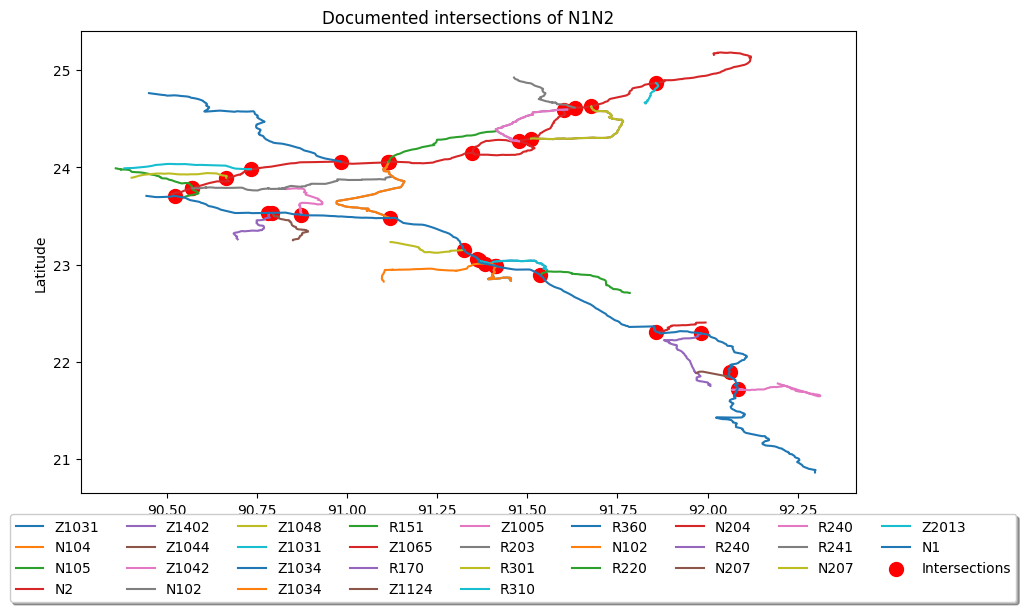

In [31]:
plt.figure(figsize=(10,6)) 
for road in documented_long_intersections_N1N2.road_to:
    plt.plot(roads[roads['road']==road]['lon'], roads[roads['road']==road]['lat'], label=road)

# # Plot N1 (not included in its own intersections)
plt.plot(roads[roads['road']=='N1']['lon'], roads[roads['road']=='N1']['lat'], label='N1')

# Make the intersections big enough and red
plt.scatter(documented_long_intersections_N1N2['lon'], documented_long_intersections_N1N2['lat'], color='red', s=100, label='Intersections')  

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc="lower left", ncol=len(documented_long_intersections_N1N2.columns), bbox_to_anchor=(-0.1, -0.25),
          fancybox=True, shadow=True) 
plt.title('Documented intersections of N1N2')

## Extract remaining roads for additional check
The 30 identified roads were all identified based on their type (either CrossRoad or SideRoad). It is however also possible that the provided dataset is incomplete to this regard. Therefore, the remaining long roads (>25km), will be extracted to a new dataframe. The 243 roads in this file will be visually inspected on possible crossings with the N1 and N2. For this analysis, see notebook 'check_remaining_crossings'. 

In [32]:
# Extract all of the roads longer than 25km, remove the already identified roads from the list and make a dataframe with the remaining ones
documented_crossings_list = documented_long_intersections_N1N2['road_to'].to_list()
possible_crossings_list = ['N1', 'N2'] + list(set(long_roads_list) - set(documented_crossings_list))
df_possible_crossings = roads[roads['road'].isin(possible_crossings_list)]
df_possible_crossings.to_csv('../data/semi-processed/possible_crossings_to_check.csv')

## Calculate the closest distance from N1 or N2 to the intersecting road

In [33]:
documented_intersections = documented_long_intersections_N1N2.copy()

# Create empty lists to store closest point information
distances_to_closest = []

# Iterate over each row in find_points DataFrame
for index, row in documented_long_intersections_N1N2.iterrows():
    # Extract coordinates of the point
    point_coords = (row['lat'], row['lon'])
    
    # Filter roads df to get points on road_to
    road_to_points = roads[roads['road'] == row['road_to']]
    
    # Calculate distances between the point and all road_to points using Haversine formula
    distances = [haversine(point_coords, (lat, lon), unit=Unit.METERS) for lat, lon in zip(road_to_points['lat'], road_to_points['lon'])]
    
    # Find the index of the closest point
    closest_point_index = distances.index(min(distances))
    
    # Calculate distance between the two points
    distance_between = distances[closest_point_index]
    
    # Append closest point information to lists
    distances_to_closest.append(distance_between)

# Add new columns to find_points DataFrame
documented_intersections['distance_to_closest'] = distances_to_closest

documented_intersections

,road,chainage,LRPName,lat,lon,gap,type,name,road_to,distance_to_closest
5,N1,140.251,LRP143a,23.047944,91.365139,NaN,crossroad,Z1031,Z1031,4.200797
6,N1,145.409,LRP148a,23.009556,91.381360,NaN,crossroad / kmpost,Intersection with N104 / Km post missing,N104,9.078352
10,N2,11.464,LRP012a,23.785333,90.568555,NaN,crossroad,Intersection with N105,N105,29.759391
13,N1,8.763,LRP009a,23.706083,90.521527,NaN,"sideroad,left",Road to Sylhet (N2),N2,20.374160
19,N1,45.322,LRP046a,23.530749,90.781610,NaN,"sideroad,right","Z1402, road to Pennai",Z1402,0.000000
21,N1,47.224,LRP047a,23.530694,90.792444,NaN,"sideroad,right",Z1044,Z1044,0.000000
22,N1,55.477,LRP056c,23.512667,90.871416,NaN,"sideroad,left","Z1042, road to Bancharampur",Z1042,3.091223
27,N1,81.846,LRP084a,23.478972,91.118166,NaN,"sideroad,left",Road to Brahmanbaria(N102),N102,2.835290
30,N1,128.009,LRP130a,23.149694,91.325499,NaN,"sideroad,right",Road to Nangolhat (Z1048),Z1048,31.387443
31,N1,138.869,LRP142a,23.061472,91.361667,NaN,"sideroad,right",Road to Karerhat (Z1031),Z1031,0.000000


In [34]:
documented_intersections.distance_to_closest.sort_values(ascending=False)

59    4849.463034
93      66.797722
87      33.466257
30      31.387443
44      31.022093
10      29.759391
79      22.922190
85      22.913984
92      22.890558
13      20.374160
95      18.737016
89      18.004838
33      14.218481
81      11.739378
88      10.470074
91       9.273670
6        9.078352
34       8.403368
77       6.788710
37       6.171327
5        4.200797
64       3.091223
22       3.091223
27       2.835290
50       0.000000
31       0.000000
21       0.000000
94       0.000000
19       0.000000
99       0.000000
Name: distance_to_closest, dtype: float64

In [35]:
## Threshold is arbitrairy on 100 meters, because we checked the one on 66 meter and it looks like they overlap in reality
intersection_threshold = 100

In [36]:
trustworthy_documented_intersections = documented_intersections[documented_intersections['distance_to_closest']< intersection_threshold]
trustworthy_documented_intersections

,road,chainage,LRPName,lat,lon,gap,type,name,road_to,distance_to_closest
5,N1,140.251,LRP143a,23.047944,91.365139,NaN,crossroad,Z1031,Z1031,4.200797
6,N1,145.409,LRP148a,23.009556,91.381360,NaN,crossroad / kmpost,Intersection with N104 / Km post missing,N104,9.078352
10,N2,11.464,LRP012a,23.785333,90.568555,NaN,crossroad,Intersection with N105,N105,29.759391
13,N1,8.763,LRP009a,23.706083,90.521527,NaN,"sideroad,left",Road to Sylhet (N2),N2,20.374160
19,N1,45.322,LRP046a,23.530749,90.781610,NaN,"sideroad,right","Z1402, road to Pennai",Z1402,0.000000
21,N1,47.224,LRP047a,23.530694,90.792444,NaN,"sideroad,right",Z1044,Z1044,0.000000
22,N1,55.477,LRP056c,23.512667,90.871416,NaN,"sideroad,left","Z1042, road to Bancharampur",Z1042,3.091223
27,N1,81.846,LRP084a,23.478972,91.118166,NaN,"sideroad,left",Road to Brahmanbaria(N102),N102,2.835290
30,N1,128.009,LRP130a,23.149694,91.325499,NaN,"sideroad,right",Road to Nangolhat (Z1048),Z1048,31.387443
31,N1,138.869,LRP142a,23.061472,91.361667,NaN,"sideroad,right",Road to Karerhat (Z1031),Z1031,0.000000


In [37]:
def find_closest(row, roads):
    intersection_coords = (row['lat'], row['lon'])
    road_to_points = roads[roads['road'] == row['road_to']]

    # Calculate distances between the intersection and all road_to points using haversine
    distances = [haversine(intersection_coords, (lat, lon), unit=Unit.METERS) for lat, lon in zip(road_to_points['lat'], road_to_points['lon'])] 
    
    # Find the index of the closest point
    closest_point_index = distances.index(min(distances))
    
    # Get the coordinates and LRPName of the closest point
    closest_lat = road_to_points.iloc[closest_point_index]['lat']
    closest_lon = road_to_points.iloc[closest_point_index]['lon']
    closest_lrp_name = road_to_points.iloc[closest_point_index]['LRPName']
    closest_name = road_to_points.iloc[closest_point_index]['name']
    closest_type= road_to_points.iloc[closest_point_index]['type']
    closest_chainage = road_to_points.iloc[closest_point_index]['chainage']
    
    # Calculate distance to the closest point
    distance_to_closest = distances[closest_point_index]
    
    return closest_lat, closest_lon, closest_lrp_name, closest_name, closest_type, closest_chainage, distance_to_closest

# Apply the function to each row of trustworthy_documented_intersections_df
closest_cols = trustworthy_documented_intersections.apply(lambda row: find_closest(row, roads), axis=1)

# Unpack the result into separate columns
trustworthy_documented_intersections[['closest_lat', 'closest_lon', 'closest_lrp', 'closest_name', 'closest_type', 'closest_chainage', 'distance_to_closest']] = pd.DataFrame(closest_cols.tolist(), index=trustworthy_documented_intersections.index)

# Set 'model_type' to 'intersection' for all rows
trustworthy_documented_intersections['model_type'] = 'intersection'

# Print or use the trustworthy_documented_intersections DataFrame as needed
trustworthy_documented_intersections[['road','road_to']]

C:\Users\emily\AppData\Local\Temp\ipykernel_6492\3507729283.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trustworthy_documented_intersections[['closest_lat', 'closest_lon', 'closest_lrp', 'closest_name', 'closest_type', 'closest_chainage', 'distance_to_closest']] = pd.DataFrame(closest_cols.tolist(), index=trustworthy_documented_intersections.index)
C:\Users\emily\AppData\Local\Temp\ipykernel_6492\3507729283.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trustworthy_documented_intersections[['

,road,road_to
5,N1,Z1031
6,N1,N104
10,N2,N105
13,N1,N2
19,N1,Z1402
21,N1,Z1044
22,N1,Z1042
27,N1,N102
30,N1,Z1048
31,N1,Z1031


In [38]:
trustworthy_documented_intersections.to_csv('../data/semi-processed/intersections_to_check_final.csv')